In [ ]:
#for development of the gridmap
import sys, os
#path2add = os.path.normpath(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir, 'dir1')))
#print(os.getcwd())
parent_path = os.path.normpath(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
#print(path2add)
sys.path.append(parent_path)
sys.path.append(os.path.normpath(os.path.join(parent_path,"gyrii")))

import json
import yaml

    
def dict_array_upend(mydict,key,elem):
    if key not in mydict:
        mydict[key]=[]
    mydict[key.append(elem)]

def load_sensor_log_file(fname):
    response=[]
    first_timestamp=0
    f=open(fname,'r')
    for line in f.readlines():        
        dat=json.loads(line)
        timestamp=dat["timestamp"]-first_timestamp
        response.append(dat)
        if first_timestamp==0:                        
            first_timestamp=timestamp
    return response,first_timestamp
        
#sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210314-114641.txt") #turns
sensor_log,first_timestamp=load_sensor_log_file("../logs/sensor_log_20210319-222551.txt") #backward from wall

In [2]:
from Gyrus import Gyrus
from TimeSeries import TimeSeries
import numpy as np

class Plotter(Gyrus):
    def __init__(self,vname,title,ylabel):
        self.value_name=vname
        self.dataseries=TimeSeries(title=title,ylabel=ylabel)
        
    
    def read_message(self,message):
        if self.value_name in message and "timestamp" in message:            
            self.dataseries.append(message["timestamp"],message[self.value_name])
        return []
    
class MotorPlotter(Gyrus):
    def __init__(self):
        self.value_name="drive/motors_active"
        ylabel="Motor fb active"
        title="Motors"
        self.dataseries=TimeSeries(title=title,ylabel=ylabel)
        
    
    def read_message(self,message):
        if self.value_name in message and "timestamp" in message:            
            self.dataseries.append(message["timestamp"],message[self.value_name][0])
        return []
    
class UltrasonicPlotter(Gyrus):
    def __init__(self):
        self.value_name="ultrasonic_sensor/last_measurement"
        self.dataseries=TimeSeries(title="Ultrasonic Distance",ylabel="Distance (m)")
        self.dataseries_unc=TimeSeries(title="Ultrasonic Distance Unc",ylabel="Distance (m)")
        self.last_timestamp=-1
        
    def read_message(self,message):
        if self.value_name in message and "timestamp" in message:            
            if self.last_timestamp!=message[self.value_name]["timestamp"]:
                self.dataseries.append(message["timestamp"],message[self.value_name]["average_distance"])
                self.dataseries_unc.append(message["timestamp"],message[self.value_name]["stdev_distance"])
                self.last_timestamp=message[self.value_name]["timestamp"]
            else:
                print("repeat ultrasonic, ignoring")
        return []
    
    
class PosePlotter(Gyrus):
    def __init__(self):
        self.x_dataseries=TimeSeries(title="Pose X",ylabel="X Position (m)")
        self.x_unc_dataseries=TimeSeries(title="Pose X Unc",ylabel="X Position Uncertainty (m)")
        self.y_dataseries=TimeSeries(title="Pose Y",ylabel="X Position (m)")
        self.y_unc_dataseries=TimeSeries(title="Pose Y Unc",ylabel="X Position Uncertainty (m)")
        self.theta_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle (radians)")
        self.theta_unc_dataseries=TimeSeries(title="Pose Theta",ylabel="Angle Uncertainty (radians)")
        
    def read_message(self,message):
        if "latest_pose" in message and "timestamp" in message:
            self.x_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][0])
            self.x_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][0][0]))
            self.y_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][1])
            self.y_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][1][1]))
            self.theta_dataseries.append(message["timestamp"],message["latest_pose"]["vals"][2])
            self.theta_unc_dataseries.append(message["timestamp"],np.sqrt(message["latest_pose"]["covariance"][2][2]))

        return []
    
class ImageDrawer(Gyrus):
    def __init__(self):
        pass
    
    def read_message(self,message):
        if "camera_frame" in message:
            if message["camera_frame"] is None:
                print("Error, none frame")
            else:
                fig,ax = plt.subplots(1)
                plt.imshow(message["camera_frame"])
                plt.show()
        return []

        
    

In [3]:
from FloorWallGyrus import FloorDetectorGyrus
import matplotlib.patches as patches
from uncertainties import unumpy


class FloorDetectorTrainer(Gyrus):
    def __init__(self):
        self.myfloordetectorgyrus=FloorDetectorGyrus(checkpoint_fname="../floor_detector_sliced.pt",debugshow=False,min_distance=-1e8)
        self.last_ultrasonic=[0,0]
        self.floor_pixel_measurements=[]
        self.ultrasonic_measurements=[]
        
    def read_message(self,message):
        #TODO record pose?  or maybe ultrasonic distance?
        if "ultrasonic_sensor/last_measurement" in message:
            self.last_ultrasonic=[message["ultrasonic_sensor/last_measurement"]["average_distance"],message["ultrasonic_sensor/last_measurement"]["stdev_distance"]]
        if "camera_frame" in message:
            ret=self.myfloordetectorgyrus.read_message(message)
            self.ultrasonic_measurements.append(self.last_ultrasonic)
            self.floor_pixel_measurements.append([self.myfloordetectorgyrus.floordetector.last_pixel_centers,self.myfloordetectorgyrus.floordetector.last_pixel_means,self.myfloordetectorgyrus.floordetector.last_pixel_stdevs])
            self.show_debug_plots(message["camera_frame"])
            #TODO record pixels, etc
            return ret
        return []
    
    def show_debug_plots(self,image):
        fig,ax = plt.subplots(1)
        #plt.imshow(image[240:480,:,:])
        plt.imshow(image)
        slice_width=40
        centers=self.myfloordetectorgyrus.floordetector.last_pixel_centers
        means=self.myfloordetectorgyrus.floordetector.last_pixel_means
        stdevs=self.myfloordetectorgyrus.floordetector.last_pixel_stdevs
        for i in range(len(self.myfloordetectorgyrus.floordetector.last_pixel_centers)):
            xs=[centers[i]-slice_width/2,centers[i]+slice_width/2]
            ys=[means[i],means[i]]
            plt.plot(xs,ys)
            ax.add_patch(patches.Rectangle((centers[i]-20,means[i]-stdevs[i]*0.5),40,stdevs[i],linewidth=1,edgecolor='r',facecolor='none'))
        plt.show()

        #plt.figure(figsize=(6,6))
        #plt.axis("equal")
        #xs=unumpy.nominal_values(dists)*np.sin(unumpy.nominal_values(x_angles))
        #ys=unumpy.nominal_values(dists)*np.cos(unumpy.nominal_values(x_angles))
        #plt.plot([ys, np.zeros(np.size(ys))], [xs, np.zeros(np.size(ys))], "ro-") # lines from 0,0 to the

        #plt.plot(xs,ys,'*')

        #plt.polar(unumpy.nominal_values(x_angles),unumpy.nominal_values(dists),'*')
        #plt.show()
        
    def plot_records(self):
        fig,ax = plt.subplots(1)
        ints=np.arange(len(self.ultrasonic_measurements))
        lu=np.array(self.ultrasonic_measurements)
        plt.title("Ultrasonic")
        plt.ylabel("Distance (m)")
        plt.errorbar(ints,lu[:,0],yerr=lu[:,1])
        plt.show()
        
        px=np.array(self.floor_pixel_measurements)
        fig,ax = plt.subplots(1)
        plt.title("first center")
        plt.ylabel("pixel")
        plt.errorbar(ints,px[:,1,0],yerr=px[:,2,0])
        plt.show()
        


        

repeat ultrasonic, ignoring
{'timestamp': 1.4831013679504395, 'saved_image': 'images/image_20210319-222552.png'}


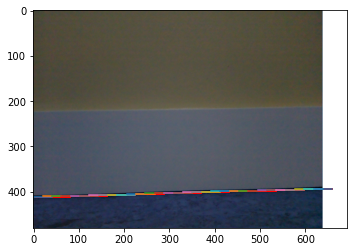

{'timestamp': 2.5237722396850586, 'saved_image': 'images/image_20210319-222553.png'}


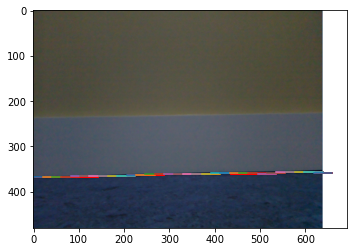

{'timestamp': 3.5384268760681152, 'saved_image': 'images/image_20210319-222554.png'}


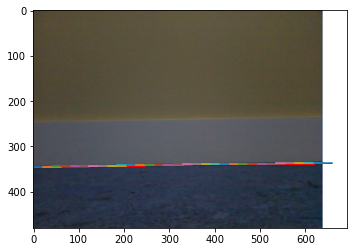

{'timestamp': 4.581916332244873, 'saved_image': 'images/image_20210319-222555.png'}


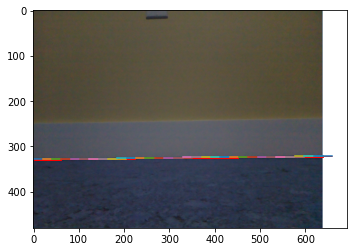

repeat ultrasonic, ignoring
{'timestamp': 5.625139236450195, 'saved_image': 'images/image_20210319-222556.png'}


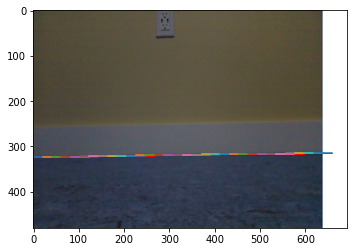

In [4]:
from PoseTrackerGyrus import PoseTrackerGyrus
from MotionGyrus import MotionEstimationGyrus
from MessageLoggerGyrus import ImageLoaderGyrus
from LocalMapGyrus import LocalMapGyrus
from matplotlib import pyplot as plt




plotters={}
plotters["compass_heading"]=Plotter("compass_heading","Compass Heading","Degrees")
plotters["ultrasonic"]=UltrasonicPlotter()
plotters["pose"]=PosePlotter()
plotters["aheadmotor"]=MotorPlotter()


gyrii=[]
#gyrii.append(PoseTrackerGyrus())
#motionestimationgyrus=MotionEstimationGyrus()
#gyrii.append(motionestimationgyrus)
localmapgyrus=LocalMapGyrus(resolution=0.01,npoints_x=200,npoints_y=200)
gyrii.append(localmapgyrus)
gyrii.append(ImageLoaderGyrus())
#gyrii.append(LocalMapPlotter(localmapgyrus))
#gyrii.append(ImageDrawer())
trainer=FloorDetectorTrainer()
gyrii.append(trainer)


for key in plotters:
    gyrii.append(plotters[key])
    
#Load existing config file into the gyrii
config_filename="../gyrus_config.yaml"
try:
    with open(config_filename,'r') as f:
        data = yaml.load(f, Loader=yaml.FullLoader)
        for g in gyrii:
            g.load_config(data)
        f.close()
except:
    print("Unable to load gyrus config file")
    
#inspect_messagename="timestamp"
inspect_messagename="saved_image"
#inspect_messagename="none"
remove_messages=["pose_offset"]
start_timestamp=sensor_log[0]["timestamp"]
for i in range(len(sensor_log)):    
    for m in remove_messages:
        if m in sensor_log[i]:            
            #print("removing {}".format(sensor_log[i]))            
            sensor_log[i].pop(m,None)
            #print("removing {}".format(sensor_log[i]))                        
    start_message=sensor_log[i]
    start_message["timestamp"]-=start_timestamp #rescale time to zero at start
    waiting_messages=[ start_message ]    
    while len(waiting_messages)!=0:
        on_message=waiting_messages.pop()
        if inspect_messagename in on_message:
            print(on_message)
        for g in gyrii:
            waiting_messages.extend(g.read_message(on_message))

C:\Users\grybk\projects\gratbot\gratbot_client\TimeSeries.py:60: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


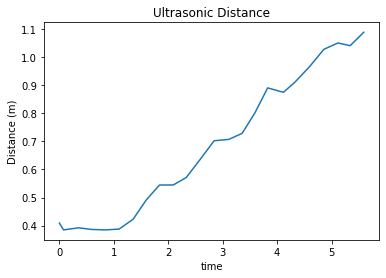

In [5]:
plotters["ultrasonic"].dataseries.plot()

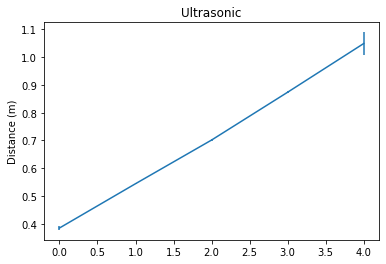

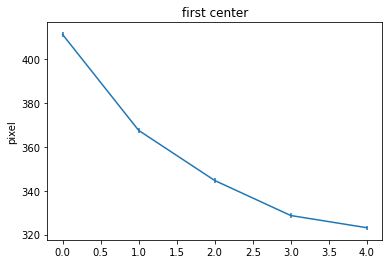

In [6]:
trainer.plot_records()

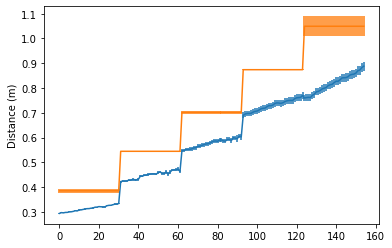

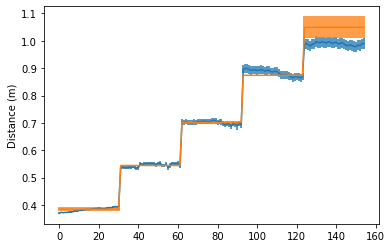

[  0.09874015 -26.0658413    8.64494683]
[[ 2.68105625e-07  2.09234033e-04 -6.12869861e-06]
 [ 2.09234033e-04  1.74979312e-01 -5.66285519e-03]
 [-6.12869861e-06 -5.66285519e-03  1.10501280e-01]]
param 0: 0.0987+/-0.0005
param 1: -26.1+/-0.4
param 2: 8.64+/-0.33


In [7]:
from scipy.optimize import least_squares
import scipy
from uncertainties import ufloat
from uncertainties.umath import *
def get_distance_from_pixels(centers,means,stdevs,image_width,image_height,x_unc=0,camera_height=0,horizon_offset=0,camera_tilt=0,camera_focal_length_pixels=0):
    #camera_focal_length_pixels=727    
    means_with_unc=unumpy.uarray(means,stdevs)
    centers_with_unc=unumpy.uarray(centers,np.ones(len(centers))*x_unc)
    x_angles=unumpy.arctan((centers_with_unc-image_width/2)/camera_focal_length_pixels)
    horizon_offset_array=horizon_offset+unumpy.nominal_values(x_angles)*camera_tilt    
    y_angles=unumpy.arctan(unumpy.cos(x_angles)*(means_with_unc-image_height/2+horizon_offset_array)/camera_focal_length_pixels)
    dists=camera_height/unumpy.tan(y_angles)
    return x_angles,dists                           


def flatten_usonic_dists(**kwargs):
    centers=kwargs["centers"]
    means=kwargs["means"]
    stdevs=kwargs["stdevs"]
    usonic_dist=kwargs["usonic_dist"]
    ret=[]
    for i in range(len(centers)):
        ret.extend(usonic_dist[i]*np.ones(len(centers[i])))
    return ret

def get_dists(x,**kwargs):
    camera_height=x[0]
    horizon_offset=x[1]
    camera_tilt=x[2]
    camera_focal_length_pixels=528 #this is from camera specs
    centers=kwargs["centers"]
    means=kwargs["means"]
    stdevs=kwargs["stdevs"]
    usonic_dist=kwargs["usonic_dist"]    
    image_width=640
    image_height=480    
    all_dists=[]
    for i in range(len(centers)):
        x_angles,dists=get_distance_from_pixels(centers[i],means[i],stdevs[i],image_width,image_height,0,camera_height,horizon_offset,camera_tilt,camera_focal_length_pixels)
        #note that I want just distance to wall so
        dists=dists*unumpy.cos(x_angles)
        all_dists.extend(dists)
    return np.array(all_dists)

def fit_fcn(x,**kwargs):
    dists=get_dists(x,**kwargs)
    udists=flatten_usonic_dists(**kwargs)
    diff=dists-udists
    resids=(unumpy.nominal_values(diff)/unumpy.std_devs(diff)).tolist()
    return resids
        
ul=np.array(trainer.ultrasonic_measurements)
px=np.array(trainer.floor_pixel_measurements)

mykwargs={
    "centers": px[:,0,:],
    "means": px[:,1,:],
    "stdevs": px[:,2,:],
    "usonic_dist": unumpy.uarray(ul[:,0],ul[:,1])    
}


fig,ax = plt.subplots(1)

x0=[0.08,-27,1]
dists=get_dists(x0,**mykwargs)
udists=flatten_usonic_dists(**mykwargs)
ints=np.arange(len(dists))

plt.ylabel("Distance (m)")
plt.errorbar(ints,unumpy.nominal_values(dists),yerr=unumpy.std_devs(dists))
plt.errorbar(ints,unumpy.nominal_values(udists),yerr=unumpy.std_devs(udists))
plt.show()

res=least_squares(fit_fcn,x0,kwargs=mykwargs)
dists=get_dists(res.x,**mykwargs)
plt.ylabel("Distance (m)")
plt.errorbar(ints,unumpy.nominal_values(dists),yerr=unumpy.std_devs(dists))
plt.errorbar(ints,unumpy.nominal_values(udists),yerr=unumpy.std_devs(udists))
plt.show()
print(res.x)
cov=scipy.linalg.pinvh((np.dot(res.jac.T,res.jac)))
print(cov)
for i in range(len(res.x)):
    print("param {}: {}".format(i,ufloat(res.x[i],np.sqrt(cov[i][i]))))
#print(fit_fcn([0.08,60,0],**mykwargs))